In [2]:
!pip install git+https://github.com/Genentech/beignet.git@simulate

  Cloning https://github.com/Genentech/beignet.git (to revision simulate) to /tmp/pip-req-build-3igb0xhq
  Running command git clone --filter=blob:none --quiet https://github.com/Genentech/beignet.git /tmp/pip-req-build-3igb0xhq
  Running command git checkout -b simulate --track origin/simulate
  Switched to a new branch 'simulate'
  Branch 'simulate' set up to track remote branch 'simulate' from 'origin'.
  Resolved https://github.com/Genentech/beignet.git to commit 81277a525ded1105fca2ee1e0fe15dcbc0a234d2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.

In [3]:
!wget https://raw.githubusercontent.com/google/jax-md/main/examples/models/sand_castle.png

--2024-07-30 02:14:59--  https://raw.githubusercontent.com/google/jax-md/main/examples/models/sand_castle.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135407 (132K) [image/png]
Saving to: ‘sand_castle.png’

sand_castle.png     100%[===================>] 132.23K  --.-KB/s    in 0.01s   

2024-07-30 02:14:59 (11.2 MB/s) - ‘sand_castle.png’ saved [135407/135407]



In [4]:
#@title Imports & Utils


# @title Utilitie"s

import base64
import dataclasses
import json

from IPython.display import HTML, JSON
import google.colab.output
import imageio.v3
import IPython
import IPython.display
import matplotlib.pyplot
import numpy
import seaborn
import torch

from beignet.func.__dataclass import _dataclass
import beignet.func

torch.set_default_tensor_type(torch.cuda.FloatTensor)

seaborn.set_style(style="white")

BACKGROUND_COLOR = [0.0] * 3

SIMULATION_INDEX = 0

TYPE_DIMENSIONS = {
    "color": 2,
    "diameter": 1,
    "neighbor_index": 2,
    "position": 2,
    "size": 1,
}


def make_from_image(filename, size_in_pixels):
    position = []
    angle = []
    color = []

    img = imageio.v3.imread(filename)

    scale = 2 ** (1 / 6)

    ratio = numpy.sqrt(1 - 0.25)

    for i, y in enumerate(range(0, img.shape[0], size_in_pixels)):
        for x in range(0, img.shape[1], size_in_pixels):
            r, g, b, a = img[y, x]

            if a == 255:
                hshift = size_in_pixels * (i % 2) / 2.0

                position += [
                    [
                        scale * (x + hshift) / size_in_pixels,
                        scale * (img.shape[0] - y) / size_in_pixels * ratio,
                    ],
                ]

                color += [[r / 255, g / 255, b / 255]]

    img_size = numpy.array(img.shape[:2]).T / size_in_pixels * scale

    box_size = numpy.max(img_size) * 1.5

    position = numpy.array(position, numpy.float64)
    position = position + box_size / 2.0 - img_size / 2

    color = numpy.array(color, numpy.float64)

    return box_size, position, color


def static_field():
    return dataclasses.field(metadata={"static": True})


def to_np(*xs):
    return [numpy.array(x) if isinstance(x, numpy.ndarray) else x for x in xs]


@_dataclass
class Disk:
    position: numpy.ndarray
    size: numpy.ndarray
    color: numpy.ndarray
    count: int = dataclasses.field(metadata={"static": True})

    def __init__(self, position, diameter=1.0, color=None):
        if color is None:
            color = numpy.array([0.8, 0.8, 1.0])

        position, diameter, color = to_np(position, diameter, color)

        object.__setattr__(self, "position", position)
        object.__setattr__(self, "size", diameter)
        object.__setattr__(self, "color", color)
        object.__setattr__(self, "count", position.shape[-2])

    def __repr__(self):
        return "Disk"


@_dataclass
class Sphere:
    position: numpy.ndarray
    size: numpy.ndarray
    color: numpy.ndarray
    count: int

    def __init__(self, position, diameter=1.0, color=None):
        if color is None:
            color = numpy.array([0.8, 0.8, 1.0])

        position, diameter, color = to_np(position, diameter, color)

        object.__setattr__(self, "position", position)
        object.__setattr__(self, "size", diameter)
        object.__setattr__(self, "color", color)
        object.__setattr__(self, "count", position.shape[-2])

    def __repr__(self):
        return "Sphere"


def _encode(R):
    dtype = R.dtype

    if dtype == numpy.float64:
        dtype = numpy.float32

    if dtype == numpy.int64:
        dtype = numpy.int32

    dtype = numpy.float32

    return base64.b64encode(numpy.array(R, dtype).tobytes()).decode("utf-8")


def _to_json(data):
    try:
        return JSON(data=data)
    except:
        return JSON(data=json.dumps(data))


def render(
    box_size,
    geometries,
    buffer_size=None,
    background_color=None,
    resolution=None,
    frame_rate=None,
    verbose=False,
):
    """Creates a rendering front-end along with callbacks in the host program.

    Args:
      box_size: A float or an array of shape `(spatial_dimension,)`. Specifies
        the size of the simulation volume. Used to position the camera.
      geometries: A dictionary containing names paired with geometric objects such
        as Disk, Sphere, or Bond.
      buffer_size: The maximum number of timesteps to send to the font-end in a
        single call.
      background_color: An array of shape (3,) specifying the background color of
        the visualization.
      resolution: The resolution of the renderer.
      frame_rate: An optional integer specifying the target frames-per-second
        for the renderer.
      verbose: Specifies whether or not the client should emit information and
        error messages. Useful for debugging visualizations, but adds clutter.
    """
    global SIMULATION_INDEX

    simulation_index = SIMULATION_INDEX

    frame_count = None
    dimension = None

    if not isinstance(geometries, dict):
        geometries = {"all": geometries}

    for geometry in geometries.values():
        if hasattr(geometry, "position"):
            assert dimension is None or geometry.position.shape[-1] == dimension

            dimension = geometry.position.shape[-1]

            if geometry.position.ndim == 3:
                assert frame_count is None or frame_count == geometry.position.shape[0]

                frame_count = geometry.position.shape[0]

    assert dimension is not None

    if isinstance(box_size, (numpy.ndarray, numpy.ndarray)):
        if box_size.shape:
            assert box_size.shape == (dimension,)

            box_size = list(box_size)
        else:
            box_size = [
                float(box_size),
            ] * dimension
    elif isinstance(box_size, float) or isinstance(box_size, int):
        box_size = [
            box_size,
        ] * dimension

    def get_metadata():
        metadata = {
            "box_size": box_size,
            "dimension": dimension,
            "geometry": [k for k in geometries.keys()],
            "simulation_idx": simulation_index,
        }

        if frame_count is not None:
            metadata["frame_count"] = frame_count

        if buffer_size is not None:
            metadata["buffer_size"] = buffer_size

        if background_color is not None:
            metadata["background_color"] = background_color

        if resolution is not None:
            metadata["resolution"] = resolution

        if frame_rate is not None:
            metadata["frame_rate"] = frame_rate

        if verbose:
            metadata["verbose"] = True

        return _to_json(metadata)

    google.colab.output.register_callback(
        "GetSimulationMetadata",
        get_metadata,
    )

    def get_dynamic_geometry_metadata(name):
        assert name in geometries

        geom = geometries[name]
        geom_dict = dataclasses.asdict(geom)

        geom_metadata = {
            "fields": {},
            "shape": str(geom),
        }

        for field in geom_dict:
            if isinstance(geom_dict[field], list):
                geom_dict[field] = numpy.array(geom_dict[field])

            if not isinstance(geom_dict[field], numpy.ndarray):
                geom_metadata[field] = geom_dict[field]

                continue

            if len(geom_dict[field].shape) == TYPE_DIMENSIONS[field] + 1:
                geom_metadata["fields"][field] = "dynamic"
            elif len(geom_dict[field].shape) == TYPE_DIMENSIONS[field]:
                geom_metadata["fields"][field] = "static"
            elif len(geom_dict[field].shape) == TYPE_DIMENSIONS[field] - 1:
                geom_metadata["fields"][field] = "global"

        return _to_json(geom_metadata)

    google.colab.output.register_callback(
        f"GetGeometryMetadata{SIMULATION_INDEX}",
        get_dynamic_geometry_metadata,
    )

    def get_array_chunk(name, field, offset, size):
        assert name in geometries

        geom = dataclasses.asdict(geometries[name])

        assert field in geom

        array = geom[field]

        if isinstance(array, list):
            array = numpy.array(array)

        return _to_json({"array_chunk": _encode(array[offset : (offset + size)])})

    google.colab.output.register_callback(
        f"GetArrayChunk{SIMULATION_INDEX}",
        get_array_chunk,
    )

    def get_array(name, field):
        assert name in geometries

        geom = dataclasses.asdict(geometries[name])

        assert field in geom

        array = geom[field]

        if isinstance(array, list):
            array = numpy.array(array)

        return _to_json({"array": _encode(array)})

    google.colab.output.register_callback(
        f"GetArray{SIMULATION_INDEX}",
        get_array,
    )

    SIMULATION_INDEX = SIMULATION_INDEX + 1

    IPython.display.display(
        HTML(
            url=(
                "https://raw.githubusercontent.com/google/jax-md/main/jax_md/colab_tools/visualization.html"
            ),
        ),
    )

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


# Sand Castle

In this demo we simulate a sand castle and then demolish it using a projectile.

## Load the sand castle

In [5]:
box, positions, colors = make_from_image('sand_castle.png', 24)

In [6]:
render(box, Disk(positions, color=colors))

In [7]:
box = torch.tensor(box, device="cuda")
positions = torch.tensor(positions, device="cuda")

In [8]:
print(f'There are {len(positions)} grains.')

There are 1616 grains.


## Spaces

In [9]:
import torch
from beignet.func import space

displacement_fn, shift_fn = space(box, parallelepiped=False, remapped=False)

In [10]:
positions[0]

tensor([73.9422, 62.5549], dtype=torch.float64)

In [11]:
displacement_fn(positions[0], positions[-1])

tensor([-27.5003,  41.7995], dtype=torch.float64)

In [12]:
shift_fn(positions[0], torch.tensor([10.0, 0.0]))

tensor([83.9422, 62.5549], dtype=torch.float64)

## Energy

"Energy" in Physics plays a similar role to "Loss" in machine learning.

Write down an energy function between two grains of sand, $\epsilon(r)$.

The total energy will be the sum of all pairs of energies.

$$E = \sum_{i,j} \epsilon(r_{ij})$$

where $r_{ij}$ is the distance between grain $i$ and grain $j$.


We want to model wet sand:

*   Grains are hard (no interpenetration).
*   Grains stick together a little bit.
*   Grains far away from one another don't notice each other.

Text(0, 0.5, '$\\epsilon$')

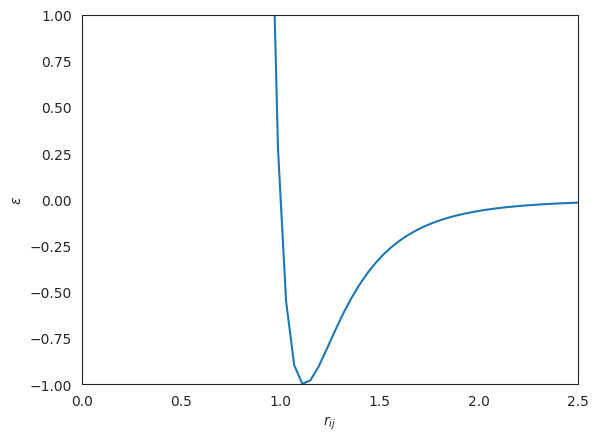

In [13]:
import matplotlib.pyplot as plt
from beignet import lennard_jones_potential

rs = torch.linspace(0.5, 2.5, steps=50)
plt.plot(rs.to(device="cpu"), lennard_jones_potential(rs, sigma=torch.tensor(1), epsilon=torch.tensor(1)).to(device="cpu"))

plt.ylim([-1, 1])
plt.xlim([0, 2.5])
plt.xlabel('$r_{ij}$')
plt.ylabel('$\\epsilon$')

In [14]:
from beignet._lennard_jones_pair_potential import lennard_jones_pair_potential

sand_energy = lennard_jones_pair_potential(displacement_fn)

sand_energy(positions)

tensor(-4977.0783, dtype=torch.float64)

## Simulate

In [15]:
simulation_steps = 10000
write_every = 50

In [16]:
from beignet.func._simulate import ensemble

setup_fn, step_fn = ensemble(sand_energy, shift_fn, step_size=torch.tensor(5e-3).to(device="cuda"), temperature=torch.tensor(0.0, device="cuda"), thermostat="Langevin", friction=1e-2)

sand = setup_fn(positions, temperature=torch.tensor(0.0, device="cuda"))

In [21]:
trajectory = []

for i in range(simulation_steps):
  print(i)
  if i % write_every == 0:
    trajectory += [sand.positions.cpu()]

  sand = step_fn(sand)

trajectory = torch.stack(trajectory)

0


OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 31.06 MiB is free. Process 3728 has 14.71 GiB memory in use. Of the allocated memory 14.53 GiB is allocated by PyTorch, and 70.42 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [1]:
render(box.cpu().detach().numpy(), Disk(trajectory.cpu().detach().numpy(), color=colors))

NameError: name 'render' is not defined

## Simulate slightly faster...

In [65]:
import torch

def simulation_fn(i, sand_trajectory, write_every, step_fn):
    sand, trajectory = sand_trajectory

    trajectory[i] = sand.positions
    for _ in range(write_every):
        sand = step_fn(sand)

    return sand, trajectory

In [66]:
write_steps = simulation_steps // write_every
n = positions.shape[0]

sand = setup_fn(positions, temperature=0.0)
trajectory = torch.zeros((write_steps, n, 2))
for i in range(write_steps):
    sand, trajectory = simulation_fn(i, (sand, trajectory), write_every, step_fn)

/usr/local/lib/python3.10/dist-packages/beignet/func/_simulate.py:308: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  step = torch.tensor(step_size).to(device=device)


In [68]:
render(box.cpu().detach().numpy(), Disk(trajectory.cpu().detach().numpy(), color=colors))

## Let's blow it up!

### The projectile

In [69]:
projectile = torch.tensor([1.0, box / 3.0])

radius = torch.tensor(2.0)
strength = 1000.0
velocity = torch.tensor([3e-2, 0.0])

Model the projectile by adding a term to the energy,

$$E = \sum_{i,j}\epsilon(r_{ij}) + \sum_i \epsilon_p(r_{ip})$$

where $r_{ip}$ is the distance between grain $i$ and the projectile.

Want the projectile to only repel the sand (no attraction).

Text(0, 0.5, '$\\epsilon$')

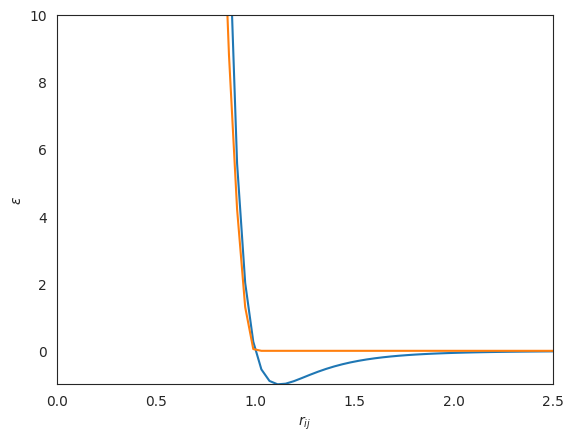

In [73]:
from beignet._soft_sphere_potential import soft_sphere_potential

rs = torch.linspace(0.5, 2.5, steps=50)
plt.plot(rs.cpu(), lennard_jones_potential(rs, sigma=torch.tensor(1,), epsilon=torch.tensor(1)).cpu())
plt.plot(rs.cpu(), soft_sphere_potential(rs, epsilon=strength).cpu())

plt.ylim([-1, 10])
plt.xlim([0, 2.5])
plt.xlabel('$r_{ij}$')
plt.ylabel('$\\epsilon$')

In [74]:
def projectile_energy(sand, projectile, radius=torch.tensor(1.0), strength=torch.tensor(1.0)):
    sand = sand.to(device="cuda")
    projectile = projectile.to(device="cuda")
    distance = torch.norm(sand - projectile, dim=-1)
    e = soft_sphere_potential(distance, sigma=radius + 1.0, epsilon=strength)
    return torch.sum(e)

def total_energy(sand, projectile, sand_energy, **kwargs):
    return sand_energy(sand) + projectile_energy(sand, projectile)

### Run the simulation

In [75]:
from beignet.func._simulate import _NVTLangevinThermostatState
import dataclasses


@dataclasses.dataclass
class SandCastle:
  sand: _NVTLangevinThermostatState
  projectile: torch.tensor

In [76]:
simulation_steps = 10000
write_every = 50
write_steps = simulation_steps // write_every

In [77]:
setup_fn, step_fn = ensemble(total_energy, shift_fn, step_size=5e-3, temperature=torch.tensor(0.0, device="cuda"), kind="NVT", thermostat="Langevin")

In [78]:
def simulation_fn(i, state_trajectory):
  state, traj = state_trajectory

  traj.sand[i] = state.sand.positions
  traj.projectile[i] = state.projectile

  def total_step_fn(_, state):
    return SandCastle(
        step_fn(state.sand, projectile=state.projectile, sand_energy=sand_energy),
        state.projectile + velocity
    )

  for i in range(write_every):
    state = total_step_fn(i, state)

  return state, SandCastle(traj.sand, traj.projectile)

In [80]:
n = positions.shape[0]

state = SandCastle(
    setup_fn(positions, projectile=projectile, sand_energy=sand_energy),
    projectile
)
trajectory = SandCastle(
    torch.zeros((write_steps, n, 2)),
    torch.zeros((write_steps, 2))
)


for i in range(write_steps):
  state, trajectory = simulation_fn(i, (state, trajectory))

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 1.06 MiB is free. Process 497576 has 14.74 GiB memory in use. Of the allocated memory 14.63 GiB is allocated by PyTorch, and 29.00 KiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
renderer.render(
    box,
    {
        'sand': renderer.Disk(trajectory.sand, color=colors),
        'projectile': renderer.Disk(trajectory.projectile[:, None, :],
                                    diameter=radius * 2)
    }
)

## Scaling Up

So far at each step we have been computing the interaction between every pair of grains.

But grains that are far apart don't affect each other.

In [81]:
box, positions, colors = make_from_image('sand_castle.png', 124)

In [82]:
len(positions)

62

In [83]:
render(box, Disk(positions, color=colors))

In [86]:
box = torch.tensor(box)
positions = torch.tensor(positions)

In [87]:
displacement_fn, shift_fn = space(box, parallelepiped=False, remapped=False)

### Neighbor lists

In [88]:
from beignet import lennard_jones_neighbor_list_potential

neighbor_fn, sand_energy = lennard_jones_neighbor_list_potential(displacement_fn, box)

In [89]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
nbrs = neighbor_fn.setup_fn(positions.to(device="cuda"))

/usr/local/lib/python3.10/dist-packages/beignet/func/_partition.py:1059: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  particle_index = torch.tensor(positions / unit_size, dtype=torch.int32, device=device)


In [90]:
nbrs.indexes.shape

torch.Size([2, 711])

In [91]:
def total_energy(sand, projectile, neighbor, **kwargs):
  return sand_energy(sand, neighbor) + projectile_energy(sand, projectile)

### Simulation

In [92]:
simulation_steps = 30000
write_every = 400
write_steps = simulation_steps // write_every

projectile = torch.tensor([1.0, box / 3.0])
radius = torch.tensor(8.0)

In [93]:
from beignet.func._partition import _NeighborList
from beignet.func._simulate import _NVTLangevinThermostatState

@dataclasses.dataclass
class SandCastle:
  sand: _NVTLangevinThermostatState
  projectile: torch.tensor
  neighbor: _NeighborList

In [94]:
from beignet.func._simulate import ensemble


init_fn, step_fn = ensemble(total_energy, shift_fn, step_size=5e-3, temperature=0.0, friction=1e-2, kind="NVT", thermostat="Langevin")

In [95]:
def simulation_fn(i, state_trajectory):
  state, traj = state_trajectory

  traj.sand[i] = state.sand.positions
  traj.projectile[i] = state.projectile

  def total_step_fn(_, state):
    sand = step_fn(state.sand,
                   projectile=state.projectile,
                   neighbor=state.neighbor)
    projectile = state.projectile + velocity
    neighbor = state.neighbor.update(state.sand.positions)
    return SandCastle(sand, projectile, neighbor)

    for _ in range(write_every):
      state = total_setp_fn(_, state)

  return state, SandCastle(traj.sand, traj.projectile, None)

In [96]:
n = positions.shape[0]

state = SandCastle(
    init_fn(positions, projectile=projectile, neighbor=nbrs),
    projectile,
    nbrs
)
trajectory = SandCastle(
    torch.zeros((write_steps, n, 2)),
    torch.zeros((write_steps, 2)),
    None
)
for i in range(write_steps):
  state, trajectory = simulation_fn(i, (state, trajectory))


In [97]:
state.neighbor.did_buffer_overflow

False

In [101]:
render(
    box.cpu(),
    {
        'sand': Disk(trajectory.sand.cpu(), color=colors),
        'projectile': Disk(trajectory.projectile[:, None, :].cpu(),
                                    diameter=radius.cpu() * 2)
    },
    buffer_size=10
)